In [1]:
##This code predicts which of the user profiles with listings in a housing website is a scammer. This dataset is a skewed dataset
#which means the number of entries with y=0 (not a scammer) is much more than y=1 (is a scammer). Therefore I am using F1 score
#as a metric to benchmark the model performance. I am using first a simple logistic regression model and then a more involved
#neural network model. Neural network has been implemented using tensorflow
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

In [2]:
##loading dataset
missing_values = ['na','--','?','-','None','none','non','null','NaN','']
X_train_temp = pd.read_csv('HA_Data_Science_Train.csv',na_values=missing_values)

In [3]:
X_train_temp.describe()


,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,HAS_PROFILE_PIC,IS_SCAMMER
count,16762.00000,16762.000000,16762.000000,16762.000000,16762.000000,16762.000000
mean,0.67826,893.245898,0.595573,50.400609,0.788390,0.057869
std,0.57137,7855.890107,0.490795,26.508424,0.408462,0.233503
min,0.00000,0.470000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,450.000000,0.000000,35.000000,1.000000,0.000000
50%,1.00000,600.000000,1.000000,50.000000,1.000000,0.000000
75%,1.00000,950.000000,1.000000,70.000000,1.000000,0.000000
max,2.00000,1000000.000000,1.000000,100.000000,1.000000,1.000000


In [4]:
X_train = X_train_temp.copy()

In [5]:
X_train.BROWSER.fillna('uknown',inplace=True)
X_train.OS.fillna('unknown',inplace=True)

In [6]:
#converting columns to categorical variables
X_train['BROWSER']=X_train['BROWSER'].astype('category')
X_train['OS']=X_train['OS'].astype('category')
X_train['LOGIN_COUNTRY_CODE']=X_train['LOGIN_COUNTRY_CODE'].astype('category')
X_train['LISTING_COUNTRY_CODE']=X_train['LISTING_COUNTRY_CODE'].astype('category')


In [7]:
#making a list of categories for different columns
browsers = list(X_train['BROWSER'].dtype.categories)
os = list(X_train['OS'].dtype.categories)
login_countries =list(X_train['LOGIN_COUNTRY_CODE'].dtype.categories)
listing_countries = list(X_train['LISTING_COUNTRY_CODE'].dtype.categories)

In [8]:
X_is_scammer = X_train[X_train['IS_SCAMMER']==1]
X_not_scammer = X_train[X_train['IS_SCAMMER']==0]

In [9]:
login_country_counts_is_scammer = X_is_scammer['LOGIN_COUNTRY_CODE'].value_counts()
login_country_counts_not_scammer = X_not_scammer['LOGIN_COUNTRY_CODE'].value_counts()

In [10]:
login_countries_list = list(login_country_counts_is_scammer.index)

In [11]:
login_countries_list_small = login_countries_list[0:16]

In [12]:
#Keeping login country same if present in above list else replace by 'other'
X_train['LOGIN_COUNTRY_CODE']=[x if x in login_countries_list_small else 'other' for x in X_train['LOGIN_COUNTRY_CODE']]

In [13]:
X_train['LISTING_COUNTRY_CODE']=[x if x in login_countries_list_small else 'other' for x in X_train['LISTING_COUNTRY_CODE']]

In [14]:
#Creating a additional Boolean column which is 1 of login and listing countries are same else 0.
X_train['login_equals_listing'] = X_train['LOGIN_COUNTRY_CODE']==X_train['LISTING_COUNTRY_CODE']

In [15]:
#converting categorical columns into numerical
X_train['login_equals_listing']=X_train['login_equals_listing'].astype('category').cat.codes
X_train['MANAGED_ACCOUNT']=X_train['MANAGED_ACCOUNT'].astype('category').cat.codes
#Converting %completenss score into a fraction
X_train['ADVERTISER_COMPLETENESS_SCORE']=X_train['ADVERTISER_COMPLETENESS_SCORE']/100

In [16]:
#Standardizing listing price
mean_price = X_train.LISTING_PRICE.mean()
stddev = X_train.LISTING_PRICE.std()

In [17]:
X_train['LISTING_PRICE']=(X_train['LISTING_PRICE']-mean_price)/stddev


In [18]:
#converting categorical columns with their one-hot vectors
OS_onehot = pd.get_dummies(X_train['OS'],prefix='OS')
BROWSER_onehot = pd.get_dummies(X_train['BROWSER'],prefix='BROWSER')

In [19]:
LOGIN_onehot = pd.get_dummies(X_train['LOGIN_COUNTRY_CODE'],prefix='LOGIN')
LISTING_onehot = pd.get_dummies(X_train['LISTING_COUNTRY_CODE'],prefix='LISTING')

In [20]:
X_train = pd.concat([X_train,OS_onehot,BROWSER_onehot,LOGIN_onehot,LISTING_onehot],axis=1)

In [21]:
X_train = X_train.drop(['LISTING_CITY','IS_ARCHIVED','ARCHIVE_REASON','ANONYMISED_EMAIL','OS','BROWSER','LOGIN_COUNTRY_CODE','LISTING_COUNTRY_CODE'],axis=1)

In [22]:
X_train = X_train.drop(['OS_BlackBerry','BROWSER_BlackBerry','LISTING_ng','BROWSER_Firefox iOS'],axis=1)

In [23]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train.drop(['IS_SCAMMER'],axis=1),X_train['IS_SCAMMER'],test_size=0.40,random_state=101)


In [24]:
#Function to compute cost for the neural network
def compute_cost(Z3,Y,beta,parameters):
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels)+beta*(tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)))
    return cost
    

In [25]:
#Function to create a model and find optimal parameter values and returned the predicted values for training and cross-validation set

def create_model(X_data,Y_data,X_test,Y_test,learning_rate=0.0001,beta = 0, num_epochs=1500):
    
    (nx,m) = X_data.shape
    (ny,m) = Y_data.shape
    X = tf.placeholder(tf.float32,shape=[nx,None])
    Y = tf.placeholder(tf.float32,shape=[ny,None])
    
    W1 = tf.get_variable("W1",[25,nx],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2",[25,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2",[25,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3",[1,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3",[1,1],initializer=tf.zeros_initializer())
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    parameters = {'W1':W1,'W2':W2,'W3':W3}
    costs=[]
    cost = compute_cost(Z3,Y,beta,parameters)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            _,epoch_cost = sess.run([optimizer,cost],feed_dict={X:X_data,Y:Y_data})
            if epoch%100 == 0:
                print('Cost after epoch %d is %f'%(epoch,epoch_cost))
            if epoch%5 ==0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        y_pred_train = (tf.sigmoid(Z3)).eval({X:X_data,Y:Y_data})
        y_pred_test =  (tf.sigmoid(Z3)).eval({X:X_test,Y:Y_test})
        
        return y_pred_train,y_pred_test
        
        
        
    

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Cost after epoch 0 is 0.755442
Cost after epoch 100 is 0.134462
Cost after epoch 200 is 0.122941
Cost after epoch 300 is 0.119300
Cost after epoch 400 is 0.117743
Cost after epoch 500 is 0.116878
Cost after epoch 600 is 0.116480
Cost after epoch 700 is 0.116250
Cost after epoch 800 is 0.116078
Cost after epoch 900 is 0.115987
Cost after epoch 1000 is 0.115884
Cost after epoch 1100 is 0.115852
Cost after epoch 1200 is 0.115802
Cost after epoch 1300 is 0.115704
Cost after epoch 1400 is 0.115571
Cost after epoch 1500 is 0.115540
Cost after

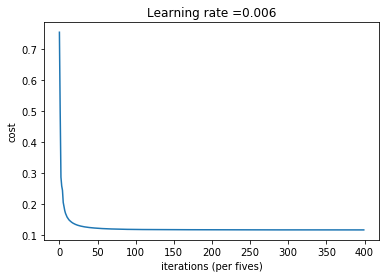

In [26]:
tf.reset_default_graph()
ny=y_train_fit.shape
y_train_fit  = y_train_fit.values.reshape((-1,1))
y_test_fit = y_test_fit.values.reshape((-1,1))
y_test_fit.shape
y_pred_train,y_pred_test = create_model(np.transpose(X_train_fit),np.transpose(y_train_fit),np.transpose(X_test_fit),np.transpose(y_test_fit),learning_rate=0.006,beta=0.0027,num_epochs=2000)

In [27]:
type(y_train_fit)




numpy.ndarray

Maximum F1 score: 0.7034611786716558
New threshold: 0.37602705


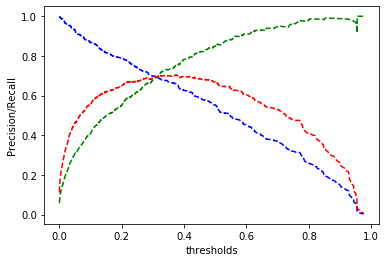

In [29]:
#calculating F1 score using calculated y values for training and test data
precision_train,recall_train,thresholds_train = precision_recall_curve(np.ravel(y_train_fit),np.ravel(np.transpose(y_pred_train)))
f1_score_train = 2*precision_train*recall_train/(precision_train+recall_train)
plt.plot(thresholds_train, precision_train[: -1], "g--", label="Precision")
plt.plot(thresholds_train, recall_train[: -1], "b--", label="Recall")
plt.plot(thresholds_train,f1_score_train[: -1],"r--",label="F1Score")
plt.xlabel('thresholds')
plt.ylabel('Precision/Recall')
print('Maximum F1 score:',max(f1_score_train))
new_threshold = thresholds_train[np.argmax(f1_score_train)] #defining new threshold for logistic regression which maximises the f1_score
print('New threshold:',new_threshold)

In [149]:
np.isnan(y_pred_test).sum()


0

Maximum F1 score: 0.7
New threshold: 0.27134076


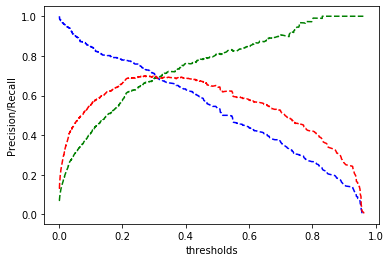

In [30]:
#Testing model on cross validation data
precision_test,recall_test,thresholds_test = precision_recall_curve(np.ravel(y_test_fit),np.ravel(np.transpose(y_pred_test)))
f1_score_test = 2*precision_test*recall_test/(precision_test+recall_test)
precision_test[-13]
plt.plot(thresholds_test, precision_test[: -1], "g--", label="Precision")
plt.plot(thresholds_test, recall_test[: -1], "b--", label="Recall")
plt.plot(thresholds_test,f1_score_test[: -1],"r--",label="F1Score")
plt.xlabel('thresholds')
plt.ylabel('Precision/Recall')
print('Maximum F1 score:',max(f1_score_test))
new_threshold = thresholds_test[np.argmax(f1_score_test)]
print('New threshold:',new_threshold)